In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys; sys.path.append('..')
import pyzx as zx
from pyzx.circuit import Circuit, CNOT, S, XPhase, QASMParser
from pyzx.phasepoly import circuit_phase_polynomial_blocks
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

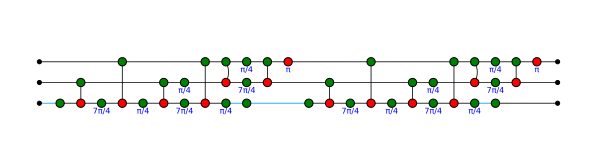

In [4]:
c = Circuit(3)
c.add_gate("TOF",0,1,2)
c.add_gate("NOT",0)
# c.add_gate("CNOT",0,1)
c.add_gate("TOF", 0,1,2)
c.add_gate("NOT",0)
# c.add_gate("CNOT", 1,2)
# c.add_gate("CCZ",0,1,2)
# c.add_gate("CCZ",2,3,4)
# c.add_gate("CCZ",4,5,6)
zx.draw(c)

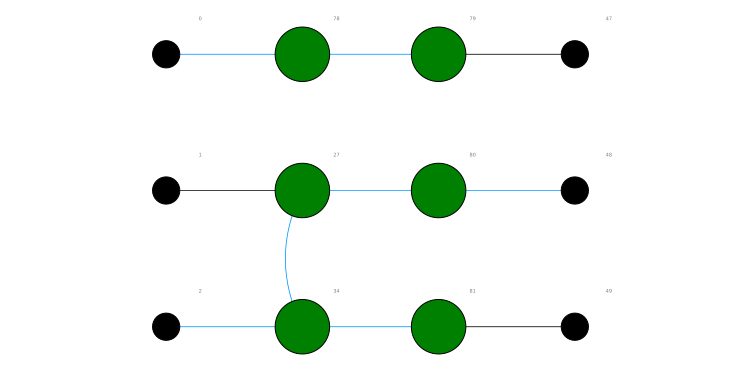

In [7]:
g = c.to_graph()
#zx.clifford_simp(g)
zx.full_reduce(g,quiet=True)
#zx.simplify.gadget_simp(g, quiet=False)
#zx.full_reduce(g,quiet=False)
# from pyzx.extract import streaming_extract
# c2 = streaming_extract(g).to_basic_gates()
# from pyzx.phasepoly import circuit_phase_polynomial_blocks
# c3, blocks = circuit_phase_polynomial_blocks(c2, optimize=True)
# zx.draw(c3.to_graph(),labels=True)
g.normalise()
#g.set_phase(94, Fraction(1,4))
#g.set_phase(96, Fraction(5,4))
zx.draw(g, labels=True, figsize=(10,5))

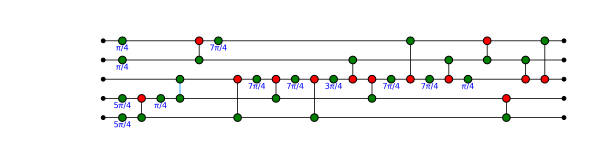

In [10]:
c = zx.extract.streaming_extract(g)
c2, blocks = circuit_phase_polynomial_blocks(c.to_basic_gates(),optimize=True)
zx.draw(c2)

[([24, 33, 11, 15], {frozenset({11, 15}): (87, 88), frozenset({24, 11, 15}): (85, 86), frozenset({33}): 33, frozenset({24, 15}): (81, 82), frozenset({33, 15}): (99, 100), frozenset({11}): 11, frozenset({24}): 24, frozenset({24, 11}): (89, 90)})]
[]


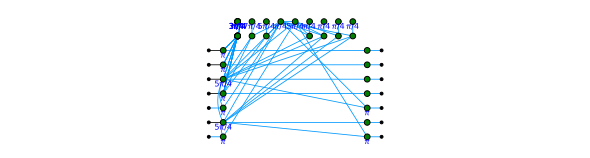

In [22]:
m = zx.rules.match_gadgets_phasepoly(g)
print(m)
zx.rules.apply_gadget_phasepoly(g, m)
zx.full_reduce(g,quiet=True)
m = zx.rules.match_gadgets_phasepoly(g)
print(m)
zx.rules.apply_gadget_phasepoly(g, m)
zx.full_reduce(g,quiet=True)
g.normalise()
zx.draw(g)

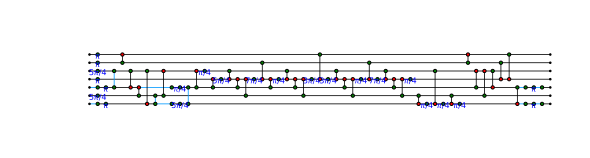

In [23]:
c2 = zx.extract.streaming_extract(g)
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
zx.draw(c3)

In [24]:
c3.tcount()

16

In [26]:
zx.compare_tensors(c,c2)

True

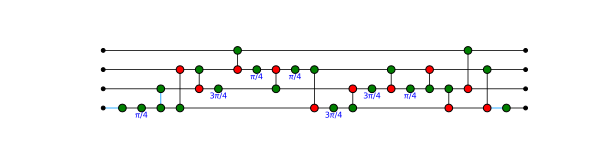

In [7]:
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
c4, blocks = circuit_phase_polynomial_blocks(c3.to_basic_gates(),optimize=True)
zx.draw(c4)

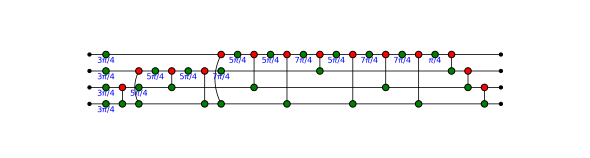

In [60]:
c2 = zx.extract.streaming_extract(g).to_basic_gates()
from pyzx.phasepoly import circuit_phase_polynomial_blocks
c3, blocks = circuit_phase_polynomial_blocks(c2, optimize=True)
zx.draw(c3.to_graph())

In [77]:
zx.compare_tensors(c.to_tensor(), zx.generate.identity(4).to_tensor())
#zx.compare_tensors(c.to_tensor(), c3.to_tensor())

True

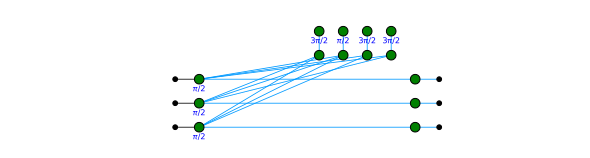

In [7]:
zx.draw(g)

False


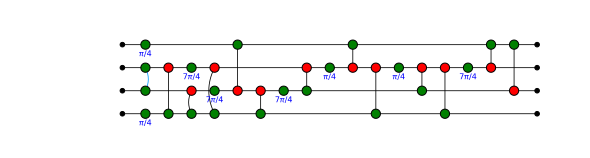

In [29]:
c4, blocks = circuit_phase_polynomial_blocks(c3, optimize=True)
print(zx.compare_tensors(c4.to_tensor(),zx.generate.identity(3).to_tensor()))
zx.draw(c4.to_graph())

In [30]:
import pyzx.quantomatic
pyzx.quantomatic.quantomatic_location = r"C:\Users\John\Desktop\scala.jar"
g3 = pyzx.quantomatic.edit_graph(c4.to_graph())

Opening Quantomatic...
Done


In [27]:
def match_phase_gadgets(g):
    phases = g.phases()

    parities = dict()
    gadgets = dict()
    for v in g.vertices():
        if phases[v] != 0 and phases[v].denominator > 2 and len(list(g.neighbours(v)))==1:
            n = list(g.neighbours(v))[0]
            gadgets[n] = v
            par = frozenset(set(g.neighbours(n)).difference({v}))
            if par in parities: parities[par].append(n)
            else: parities[par] = [n]

    m = []
    for par, gad in parities.items():
        if len(gad) == 1: continue
        totphase = sum(phases[gadgets[n]] for n in gad)%2
        n = gad.pop()
        v = gadgets[n]
        m.append((v,totphase, gad, [gadgets[n] for n in gad]))

    return m

match_phase_gadgets(g)

[(67, Fraction(3, 2), [54], [55]),
 (65, Fraction(1, 2), [52], [53]),
 (71, Fraction(3, 2), [58], [59]),
 (63, Fraction(3, 2), [50], [51])]

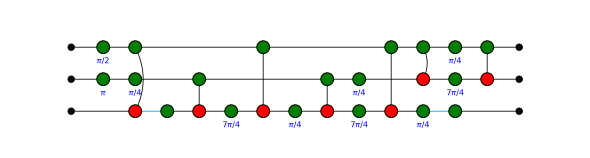

In [21]:
c2 = Circuit.from_graph(g)
zx.draw(c2.to_graph())

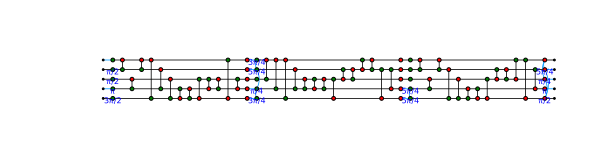

In [32]:
random.seed(1337)
g = zx.generate.cliffordT(5,70,0.15)
zx.simplify.clifford_simp(g,quiet=True)
zx.extract.circuit_extract(g)
zx.draw(g)

In [33]:
Circuit.from_graph(g).gates

[S(1),
 S(2),
 S*(4),
 HAD(3),
 Z(3),
 HAD(0),
 CNOT(0,1),
 CNOT(2,3),
 CNOT(0,1),
 CNOT(0,4),
 CNOT(1,3),
 CNOT(2,4),
 CNOT(4,3),
 CNOT(3,4),
 CNOT(4,2),
 CNOT(3,2),
 CNOT(2,3),
 CNOT(4,0),
 CNOT(3,2),
 HAD(3),
 T(3),
 HAD(4),
 Z(4),
 T*(4),
 CZ(4,3),
 HAD(0),
 Z(0),
 T*(0),
 HAD(1),
 Z(1),
 T(1),
 CZ(1,0),
 CZ(1,3),
 CNOT(0,2),
 CNOT(0,3),
 CNOT(0,4),
 CNOT(1,3),
 CNOT(2,3),
 CNOT(3,2),
 CNOT(2,3),
 CNOT(4,2),
 CNOT(2,1),
 CNOT(1,2),
 CNOT(1,0),
 CNOT(0,1),
 CNOT(4,1),
 CNOT(3,1),
 HAD(3),
 Z(3),
 T(3),
 HAD(4),
 Z(4),
 T(4),
 CZ(4,3),
 CNOT(0,1),
 CNOT(2,3),
 CNOT(0,1),
 CNOT(1,4),
 CNOT(2,4),
 CNOT(3,4),
 CNOT(4,3),
 CNOT(4,2),
 CNOT(2,1),
 CNOT(1,2),
 CNOT(2,0),
 CNOT(4,0),
 CNOT(3,1),
 XPhase(4,phase=1/2),
 XPhase(1,phase=5/4),
 CX(1,0),
 CX(1,4),
 XPhase(2,phase=1/4),
 CX(2,0),
 CX(2,4),
 NOT(3),
 HAD(1),
 HAD(2),
 HAD(3)]

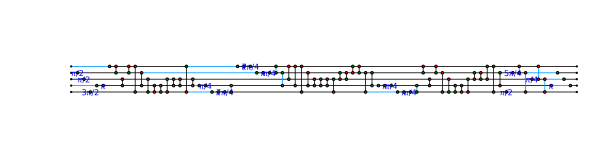

In [34]:
zx.draw(Circuit.from_graph(g).to_graph())

In [37]:
t = zx.tensor.tensorfy(g)
t2 = zx.tensor.tensorfy(Circuit.from_graph(g).to_graph())
zx.tensor.compare_tensors(t,t2)

True

[HAD(4), CCZ(c1=0,c2=1,t=4), HAD(4), HAD(3), CCZ(c1=2,c2=4,t=3), HAD(3), HAD(4), CCZ(c1=0,c2=1,t=4), HAD(4)]


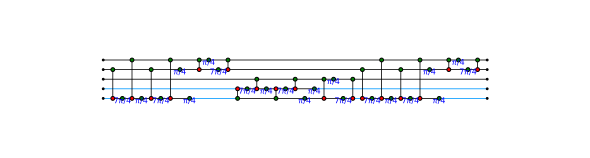

In [78]:
import os
c = Circuit.from_quipper_file(os.path.abspath("..\\circuits\\tof_3_after_light.txt"))
c = Circuit.from_quipper_file(os.path.abspath("..\\circuits\\tof_3_before.txt"))
print(c.gates)
g = c.to_graph()
zx.simplify.id_simp(g,quiet=True)
g.pack_circuit_rows()
zx.draw(g)

In [87]:
s = """OPENQASM 2.0;
include "qelib1.inc";

gate ccx a,b,c
{
h c;
cx b,c; tdg c;
cx a,c; t c;
cx b,c; tdg c;
cx a,c; t b; t c; h c;
cx a,b; t a; tdg b;
cx a,b;
}

qreg q[3];
ccx q[0], q[1], q[2];
"""
p = QASMParser()
c = p.parse(s)
g = c.to_graph()
# zx.simplify.clifford_simp(g,quiet=True)
# c2 = zx.extract.streaming_extract(g)
# import pyzx.phasepoly
# c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c2,optimize=True)
# #zx.simplify.id_simp(g,quiet=True)
# zx.draw(c3.to_graph(compress_rows=True),figsize=(12,4))

In [89]:
c = zx.Circuit(3)
c.add_gate("TOF", 0,1,2)
c2 = zx.Circuit(3)
c2.add_gate("HAD", 2)
c2.add_gate("CCZ",0,1,2)
c2.add_gate("HAD",2)
zx.compare_tensors(c.to_tensor(),c2.to_tensor())

True

id_simp
16. 11. 1. 
finished in 4 iterations


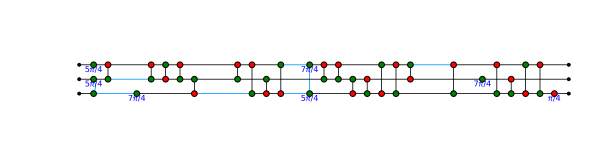

In [22]:
zx.simplify.clifford_simp(g, quiet=True)
zx.extract.circuit_extract(g)
zx.simplify.id_simp(g)
zx.draw(g)

In [94]:
import os
f = os.path.abspath("../circuits/QFT_and_Adders/Adder8_before")
c = Circuit.from_quipper_file(f)
c.gates[:10]

[CNOT(7,15),
 NOT(15),
 Tof(c1=7,c2=15,t=16),
 NOT(15),
 CNOT(6,14),
 CNOT(16,14),
 NOT(14),
 Tof(c1=6,c2=14,t=17),
 NOT(14),
 Tof(c1=6,c2=16,t=17)]

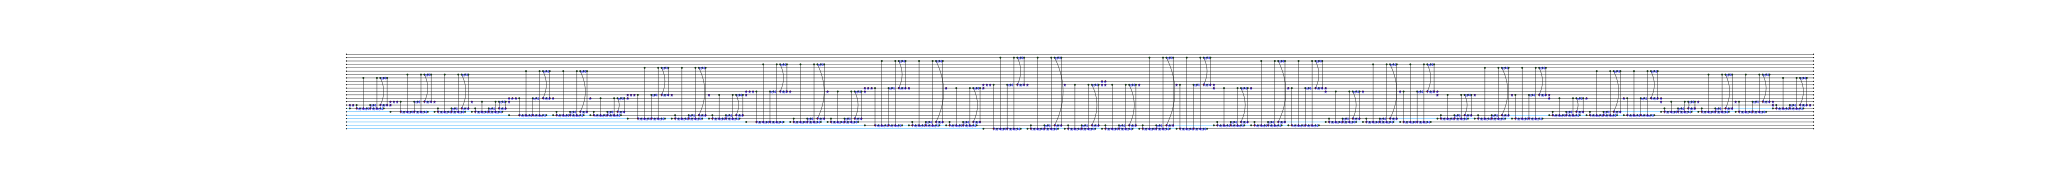

In [23]:
zx.draw(c.to_graph(),figsize=(60,5))

In [44]:
g = c.to_graph()
#zx.simplify.clifford_simp(g,quiet=True)
zx.simplify.full_reduce(g,quiet=False)
print("tcount", zx.t_count(g))
c2 = zx.extract.streaming_extract(g)
print(len(c2.gates))
g = c2.to_graph()
zx.simplify.to_gh(g)
zx.simplify.id_simp(g,quiet=True)
c3 = zx.Circuit.from_graph(g, split_phases=False)
print(len(c3.gates))
import pyzx.phasepoly
c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c3, optimize=True)
print(c3.stats())
#zx.draw(c3.to_graph(compress_rows=True),figsize=(30,6))

spider_simp: 76. 65. 39. 16. 12. 9. 7. 6.  8 iterations
id_simp: 51. 32.  2 iterations
pivot_simp: 16.  1 iterations
Gadgetizing...
pivot_simp: 90. 38. 27. 13. 9. 6. 6. 2.  8 iterations
id_simp: 13.  1 iterations
spider_simp: 9. 2.  2 iterations
pivot_simp: 6. 6. 2. 2.  4 iterations
id_simp: 14.  1 iterations
spider_simp: 6. 4.  2 iterations
lcomp_simp: 5. 5. 4. 4.  4 iterations
id_simp: 6.  1 iterations
spider_simp: 3. 2.  2 iterations
pivot_simp: 3. 1.  2 iterations
lcomp_simp: 1. 1.  2 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
lcomp_simp: 1. 1.  2 iterations
gadget_simp: 28.  1 iterations
gadget_simp found matches!
lcomp_simp: 28. 28.  2 iterations
pivot_simp: 1.  1 iterations
tcount 100
957
1803
Circuit on 19 qubits with 1094 gates.
        100 T-like gates
        994 Cliffords among which 
        746 2-qubit gates and 240 Hadamard gates.


In [56]:
from pyzx.circuit import ZPhase
isinstance(c3.gates[0],ZPhase)

True

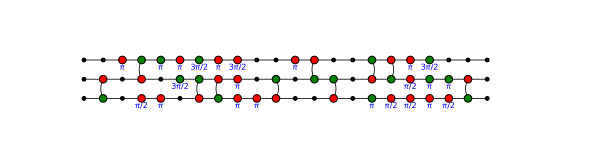

In [14]:
import os
file_name = os.path.abspath("..\\circuits\\small.qgraph")
with open(file_name, 'r') as qgraph:
    js = qgraph.read()
    g3 = zx.json_to_graph(js)
    js = zx.graph_to_json(g3)
    g3 = zx.json_to_graph(js)
zx.draw(g3)
#print(g3.depth())

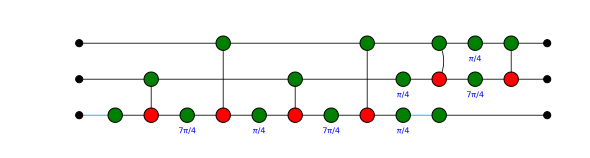

In [39]:
zx.draw(g)

In [18]:
import tempfile
import os
import sys
import shutil
import subprocess

def edit_in_quantomatic(g):
    fname = os.path.abspath(r"..\main.qproject")
    with tempfile.TemporaryDirectory() as tmpdirname:
        print('created temporary directory', tmpdirname)
        shutil.copy(fname, tmpdirname)
        projectname = os.path.join(tmpdirname, "main.qproject")
        js = zx.graph_to_json(g)
        fname = os.path.join(tmpdirname, "pyzxgraph.qgraph")
        with open(fname,'w') as f:
            f.write(js)
        print("Opening Quantomatic...")
        subprocess.call(r"java -jar C:\Users\John\Desktop\scala.jar {} {}".format(projectname, fname))
        print("Done")
        with open(fname, 'r') as f:
            js = f.read()
            g = zx.json_to_graph(js)
    return g

g2 = edit_in_quantomatic(g)

created temporary directory C:\Users\John\AppData\Local\Temp\tmpopf3tik5
Opening Quantomatic...
Done


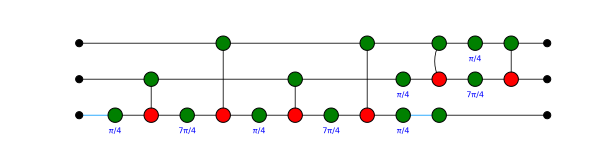

In [19]:
zx.draw(g2)

In [25]:
fname = os.path.abspath(r"../main.qproject")
fname

'C:\\Users\\John\\Documents\\Projects\\pyzx\\main.qproject'

In [40]:
import pyzx.quantomatic
pyzx.quantomatic.quantomatic_location = r"C:\Users\John\Desktop\scala.jar"
g3 = pyzx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


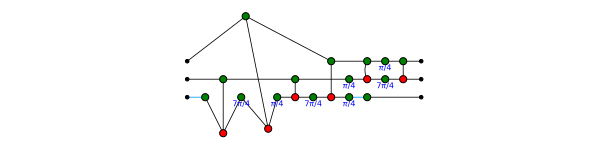

In [41]:
zx.draw(g3)